# Исследование и выбор модели для классификации изображений

**Цель:** В этом ноутбуке мы проведем исследование, чтобы выбрать лучшую модель для классификации изображений музыкальных инструментов. Мы загрузим и проанализируем данные, проведем эксперименты с двумя различными архитектурами моделей (`EfficientNet-B0` и `ResNet18`), сравним их производительность и выберем лучшую для дальнейшего использования.

## 1. Настройка окружения и загрузка данных

In [6]:
import json
import os
import random
import sys
import time
from dataclasses import asdict, dataclass
from pathlib import Path

try:
    PROJECT_ROOT = Path(__file__).resolve().parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd().parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timm
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from experiments.config import TransformedDataset, ExperimentConfig


# Фиксация для воспроизводимости
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(11)

# Глобальные переменные
ROOT_DIR = Path(PROJECT_ROOT)
DATA_PATH = ROOT_DIR / 'experiments' / 'data' / 'raw'
MODELS_DIR = ROOT_DIR / 'experiments' / 'models'
GRAPHICS_DIR = ROOT_DIR / 'experiments' / 'notebooks' / 'graphics'
MODELS_DIR.mkdir(exist_ok=True)
INPUT_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f'Using device: {DEVICE}')

Using device: cpu


## 2. Анализ и подготовка данных

Названия классов: ['harp', 'piano', 'violin']
Общее количество изображений: 120
Количество изображений по классам: {'harp': 40, 'piano': 40, 'violin': 40}
Размер обучающей выборки: 96
Размер валидационной выборки: 24


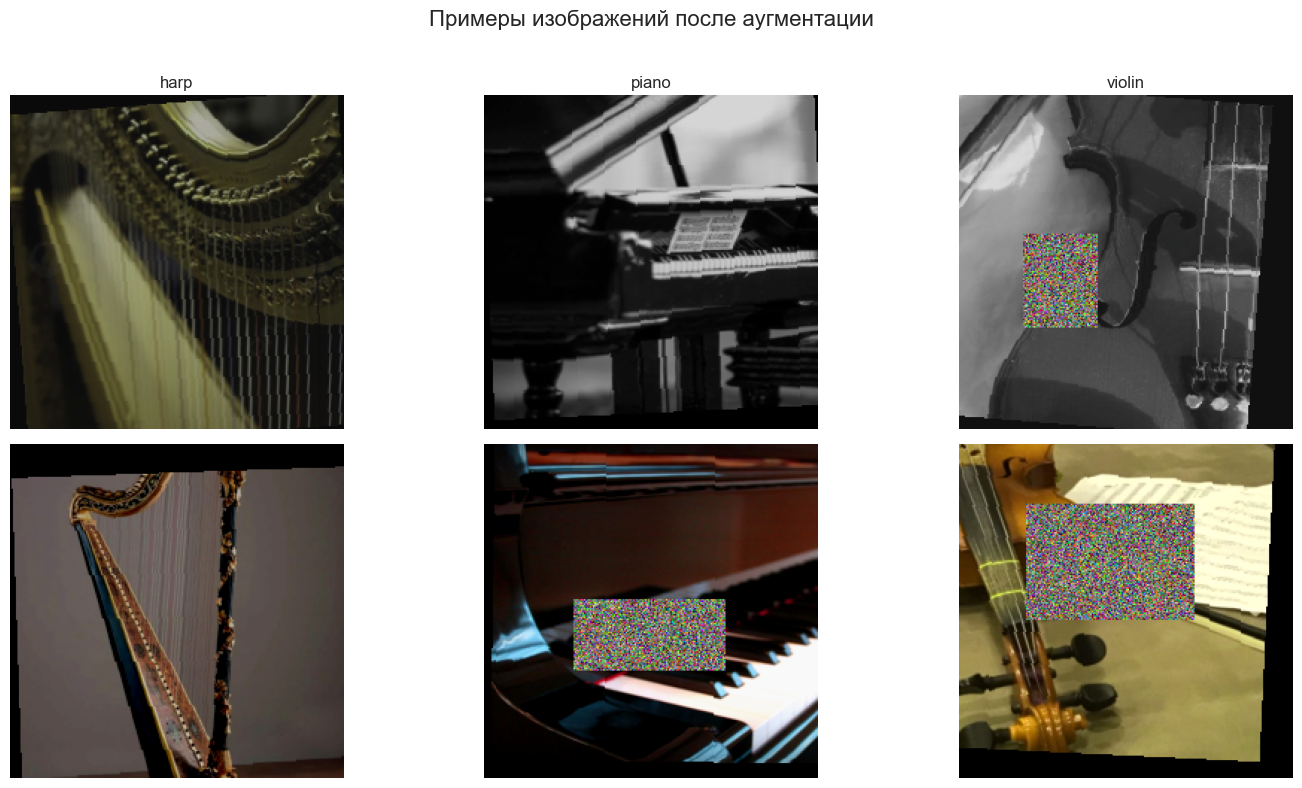

In [7]:
# 1. Загрузка данных из папок.
# ImageFolder автоматически определяет классы по названиям поддиректорий.
full_dataset = datasets.ImageFolder(DATA_PATH)
class_names = full_dataset.classes

# 2. Анализ сбалансированности датасета — подсчитываем количество изображений в каждом классе.
class_counts = {k: 0 for k in class_names}
for _, label_idx in full_dataset.samples:
    class_counts[class_names[label_idx]] += 1

print(f'Названия классов: {class_names}')
print(f'Общее количество изображений: {len(full_dataset)}')
print('Количество изображений по классам:', class_counts)

train_transforms = transforms.Compose([
    # --- Геометрические аугментации ---
    transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.4, 1.0)),   # Случайно вырезаем и меняем размер, имитируя зум.
    transforms.RandomHorizontalFlip(),                           # Горизонтально отражаем с вероятностью 50%.
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),     # Поворачиваем и сдвигаем, имитируя разные ракурсы.
    # --- Цветовые аугментации --
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.1, hue=0.1), # Меняем яркость, контраст и цвет, имитируя освещение.
    transforms.RandomGrayscale(p=0.2),                           # Превращаем в Ч/Б, чтобы модель учила формы, а не цвет.
    # --- Технические преобразования ---
    transforms.ToTensor(),                                       # Преобразуем изображение в тензор PyTorch.
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Нормализуем тензор под стандарт ImageNet.
    # --- Аугментация с "перекрытием" ---
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random') # "Стираем" часть, чтобы учить по разным деталям.
])

# 4. Конвейер для валидации. Здесь только приведение к стандарту
val_transforms = transforms.Compose([
    # Сначала увеличиваем изображение чуть больше целевого размера.
    transforms.Resize(INPUT_SIZE + 32),
    # Вырезаем центральную часть нужного размера.
    transforms.CenterCrop(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# 5. Разделение датасета на обучающую (80%) и валидационную (20%) выборки.
val_split = 0.2
dataset_size = len(full_dataset)
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# 6. Создание кастомных датасетов с применением соответствующих трансформаций.
train_dataset = TransformedDataset(train_subset, transform=train_transforms)
val_dataset = TransformedDataset(val_subset, transform=val_transforms)

# 7. Создание DataLoader'ов для подачи данных в модель пакетами (батчами).
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f'Размер обучающей выборки: {len(train_dataset)}')
print(f'Размер валидационной выборки: {len(val_dataset)}')


# --- Визуализация на класс ---

# Создаем сетку для изображений: 2 ряда, и по столбцу для каждого класса.
fig, axes = plt.subplots(2, len(class_names), figsize=(15, 8))
fig.suptitle('Примеры изображений после аугментации', fontsize=16)

# Тензоры для отмены нормализации.
mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

for i, class_name in enumerate(class_names):
    # Находим все изображения для текущего класса.
    class_indices = [idx for idx in train_subset.indices if full_dataset.targets[idx] == i]

    for j in range(2):
        ax = axes[j, i]
        
        if len(class_indices) > j:
            sample_idx = class_indices[j]
            img, label = full_dataset[sample_idx]
            
            # Применяем аугментации.
            img_aug_tensor = train_transforms(img)

            # Готовим тензор к отображению: денормализация, обрезка, смена осей.
            img_to_show = torch.clamp(img_aug_tensor * std + mean, 0, 1).permute(1, 2, 0)
            
            ax.imshow(img_to_show)
            if j == 0:
                ax.set_title(class_name) # Подписываем только верхнее фото.
        
        ax.axis('off') # Убираем рамки и оси.

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. Эксперименты с моделями

In [8]:
# --- Функции для одного цикла обучения и валидации (без изменений) ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Проводит один полный проход (эпоху) обучения по всем данным из dataloader."""
    
    # Переводим модель в режим обучения (включаем dropout, batchnorm и т.д.).
    model.train()
    
    # Инициализируем переменные для подсчета потерь и точности.
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Итерируемся по батчам данных из загрузчика.
    for inputs, labels in dataloader:
        # Перемещаем данные и метки на выбранное устройство.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Обнуляем градиенты, чтобы они не накапливались с прошлых батчей.
        optimizer.zero_grad()
        
        # Делаем предсказание (прямой проход).
        outputs = model(inputs)
        # Вычисляем ошибку (loss) между предсказаниями и реальными метками.
        loss = criterion(outputs, labels)
        
        # Вычисляем градиенты (обратный проход).
        loss.backward()
        # Обновляем веса модели на основе градиентов.
        optimizer.step()
        
        # Собираем статистику по эпохе.
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_predictions += inputs.size(0)
        
    # Возвращаем средние потери и точность за эпоху.
    return running_loss / total_predictions, (correct_predictions.float() / total_predictions).item()


def validate_epoch(model, dataloader, criterion, device):
    """Проводит один полный проход валидации для оценки качества модели."""
    
    # Переводим модель в режим оценки (отключаем dropout, batchnorm).
    model.eval()
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Отключаем вычисление градиентов для экономии памяти и ускорения.
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += inputs.size(0)
            
    # Возвращаем средние потери и точность за эпоху.
    return running_loss / total_predictions, (correct_predictions.float() / total_predictions).item()


# --- Основной цикл, управляющий всем процессом обучения (С ДОБАВЛЕНИЕМ РАННЕЙ ОСТАНОВКИ) ---

def run_training_loop(model, model_name, train_loader, val_loader, config):
    """Управляет двухэтапным процессом обучения с возможностью ранней остановки."""
    
    # Словарь для хранения истории обучения (потери и точность на каждой эпохе).
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0 # Будем хранить здесь точность лучшей модели
    start_time = time.time()

    # --- Новые параметры для ранней остановки (Early Stopping) ---
    # Количество эпох без улучшения валидационных потерь, после которого обучение остановится.
    patience = config.get('patience', 5) # Берем из конфига, если нет - по умолчанию 5
    # Счетчик эпох без улучшений.
    epochs_no_improve = 0
    # Храним лучшее значение потерь. Начинаем с бесконечности.
    best_val_loss = float('inf')
    # Флаг, который станет True, если нужно прервать обучение.
    early_stop_triggered = False

    # --- Этап 1: Feature Extraction (обучение только "головы" модели) ---
    # На этом этапе мы "замораживаем" все слои, кроме последнего, и обучаем только его.
    print(f'--- Этап 1: Feature Extraction ({config["freeze_epochs"]} эпох) ---')
    
    # "Замораживаем" все параметры модели.
    for param in model.parameters():
        param.requires_grad = False
    
    # "Размораживаем" только параметры последнего слоя (классификатора).
    if hasattr(model, 'classifier'):
        for param in model.classifier.parameters(): param.requires_grad = True
    elif hasattr(model, 'fc'):
        for param in model.fc.parameters(): param.requires_grad = True
        
    # Перемещаем модель на нужное устройство.
    model.to(DEVICE)
    # Создаем оптимизатор, который будет обновлять веса только размороженных слоев.
    optimizer = Adam(model.parameters(), lr=config['lr_head'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(config['freeze_epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
        print(f'Epoch {epoch+1}/{config["freeze_epochs"]} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc); history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        
        # --- Логика ранней остановки ---
        # Если текущие потери на валидации лучше (меньше), чем лучшие до сих пор.
        if val_loss < best_val_loss:
            # Обновляем лучшие потери.
            best_val_loss = val_loss
            # Сохраняем точность, соответствующую лучшей модели.
            best_val_acc = val_acc
            # Сбрасываем счетчик эпох без улучшений.
            epochs_no_improve = 0
            # Сохраняем модель как лучшую.
            torch.save(model.state_dict(), MODELS_DIR / f'best_{model_name}.pth')
        else:
            # Если улучшения нет, увеличиваем счетчик.
            epochs_no_improve += 1
        
        # Если счетчик превысил "терпение", останавливаем обучение.
        if epochs_no_improve >= patience:
            print(f'Ранняя остановка! Валидационные потери не улучшались {patience} эпох.')
            early_stop_triggered = True
            break # Выходим из цикла эпох

    # --- Этап 2: Full Fine-Tuning (дообучение всей модели) ---
    # Переходим ко второму этапу, только если не сработала ранняя остановка.
    if not early_stop_triggered:
        # Теперь мы "размораживаем" всю модель и обучаем все слои, но с очень маленькой скоростью.
        print(f'\n--- Этап 2: Full Fine-Tuning ({config["unfreeze_epochs"]} эпох) ---')
        
        # Сбрасываем счетчик для второго этапа, чтобы дать ему новый шанс.
        epochs_no_improve = 0
        print(f'Счетчик ранней остановки сброшен.')

        # "Размораживаем" все параметры.
        for param in model.parameters():
            param.requires_grad = True
            
        # Создаем новый оптимизатор для всех параметров с пониженной скоростью обучения.
        optimizer = Adam(model.parameters(), lr=config['lr_full'])
        # Добавляем планировщик, который будет плавно изменять скорость обучения.
        scheduler = CosineAnnealingLR(optimizer, T_max=config['unfreeze_epochs'])

        for epoch in range(config['unfreeze_epochs']):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
            print(f'Epoch {epoch+1+config["freeze_epochs"]}/{config["freeze_epochs"]+config["unfreeze_epochs"]} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc); history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            
            # --- Повторяем ту же логику ранней остановки ---
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                epochs_no_improve = 0
                torch.save(model.state_dict(), MODELS_DIR / f'best_{model_name}.pth')
            else:
                epochs_no_improve += 1
                
            if epochs_no_improve >= patience:
                print(f'Ранняя остановка! Валидационные потери не улучшались {patience} эпох.')
                break # Выходим из цикла эпох
                
            # Делаем шаг планировщика для обновления скорости обучения.
            scheduler.step()

    total_time = time.time() - start_time
    print(f'\nОбучение завершено за {total_time:.2f}с. Лучшая точность на валидации: {best_val_acc:.4f}')
    return history, total_time, best_val_acc

#### Эксперимент 1: EfficientNet-B0

In [9]:

effnet_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(class_names))
effnet_params = sum(p.numel() for p in effnet_model.parameters() if p.requires_grad)
print(f'Количество обучаемых параметров в EfficientNet-B0: {effnet_params:,}')

effnet_config = {
    # Количество эпох для обучения только 'головы' модели (последнего слоя)
    'freeze_epochs': 3, 
    # Количество эпох для дообучения всей модели
    'unfreeze_epochs': 7, 
    'lr_head': 1e-3, 
    'lr_full': 1e-4,
    'patience': 3
}

effnet_history, effnet_time, effnet_best_acc = run_training_loop(effnet_model, 'efficientnet_b0', train_loader, val_loader, effnet_config)

Количество обучаемых параметров в EfficientNet-B0: 4,011,391
--- Этап 1: Feature Extraction (3 эпох) ---


C:\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/3 | Train Loss: 3.2819 Acc: 0.3438 | Val Loss: 2.2398 Acc: 0.3750
Epoch 2/3 | Train Loss: 3.1986 Acc: 0.3542 | Val Loss: 1.9949 Acc: 0.5000
Epoch 3/3 | Train Loss: 3.0354 Acc: 0.4062 | Val Loss: 1.7785 Acc: 0.5000

--- Этап 2: Full Fine-Tuning (7 эпох) ---
Счетчик ранней остановки сброшен.
Epoch 4/10 | Train Loss: 2.6132 Acc: 0.4167 | Val Loss: 0.5738 Acc: 0.7500
Epoch 5/10 | Train Loss: 0.8573 Acc: 0.7500 | Val Loss: 0.2322 Acc: 0.9583
Epoch 6/10 | Train Loss: 0.5005 Acc: 0.8333 | Val Loss: 0.0972 Acc: 0.9583
Epoch 7/10 | Train Loss: 0.2231 Acc: 0.9167 | Val Loss: 0.0521 Acc: 1.0000
Epoch 8/10 | Train Loss: 0.1887 Acc: 0.9375 | Val Loss: 0.0457 Acc: 1.0000
Epoch 9/10 | Train Loss: 0.1510 Acc: 0.9688 | Val Loss: 0.0413 Acc: 1.0000
Epoch 10/10 | Train Loss: 0.1235 Acc: 0.9688 | Val Loss: 0.0517 Acc: 0.9583

Обучение завершено за 268.89с. Лучшая точность на валидации: 1.0000


#### Эксперимент 2: ResNet18

In [10]:
resnet_model = timm.create_model('resnet18', pretrained=True, num_classes=len(class_names))
resnet_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f'Количество обучаемых параметров в ResNet18: {resnet_params:,}')

resnet_config = {
    # Количество эпох для обучения только 'головы' модели (последнего слоя)
    'freeze_epochs': 3,
    # Количество эпох для дообучения всей модели
    'unfreeze_epochs': 7,
    'lr_head': 1e-3,
    'lr_full': 1e-4,
    'patience': 3
}

resnet_history, resnet_time, resnet_best_acc = run_training_loop(resnet_model, 'resnet18', train_loader, val_loader, resnet_config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

C:\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\krish\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Количество обучаемых параметров в ResNet18: 11,178,051
--- Этап 1: Feature Extraction (3 эпох) ---
Epoch 1/3 | Train Loss: 1.1378 Acc: 0.2812 | Val Loss: 1.0547 Acc: 0.4583
Epoch 2/3 | Train Loss: 1.0725 Acc: 0.4375 | Val Loss: 0.9973 Acc: 0.5833
Epoch 3/3 | Train Loss: 1.0107 Acc: 0.5729 | Val Loss: 0.9290 Acc: 0.6667

--- Этап 2: Full Fine-Tuning (7 эпох) ---
Счетчик ранней остановки сброшен.
Epoch 4/10 | Train Loss: 0.9795 Acc: 0.6562 | Val Loss: 0.9032 Acc: 0.7500
Epoch 5/10 | Train Loss: 0.9635 Acc: 0.6875 | Val Loss: 0.8805 Acc: 0.7917
Epoch 6/10 | Train Loss: 0.9299 Acc: 0.7708 | Val Loss: 0.8604 Acc: 0.8750
Epoch 7/10 | Train Loss: 0.9113 Acc: 0.7917 | Val Loss: 0.8463 Acc: 0.8750
Epoch 8/10 | Train Loss: 0.9046 Acc: 0.8229 | Val Loss: 0.8371 Acc: 0.9167
Epoch 9/10 | Train Loss: 0.8839 Acc: 0.8333 | Val Loss: 0.8350 Acc: 0.9167
Epoch 10/10 | Train Loss: 0.8907 Acc: 0.8542 | Val Loss: 0.8381 Acc: 0.9167

Обучение завершено за 262.37с. Лучшая точность на валидации: 0.9167


## 4. Оценка и сравнение результатов

--- Результаты EfficientNet-B0 ---
Сохранено: C:\Users\krish\OneDrive\Desktop\ml1-music-finetuning\ml1-music-finetuning\experiments\reports\figures\training_curves_efficientnet_b0.png


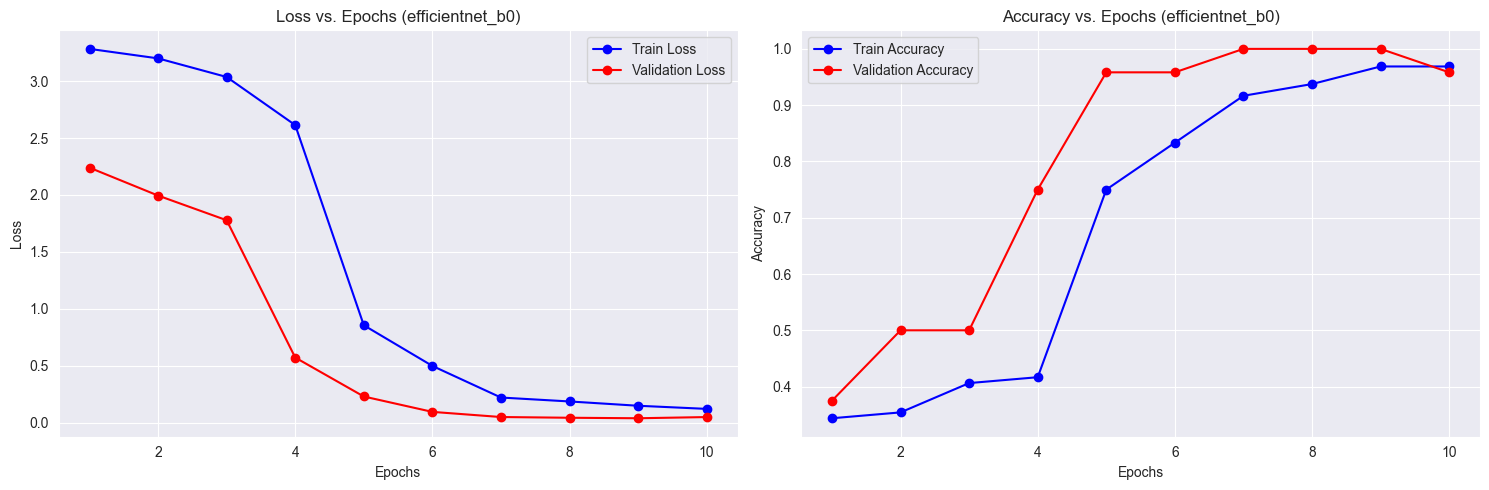

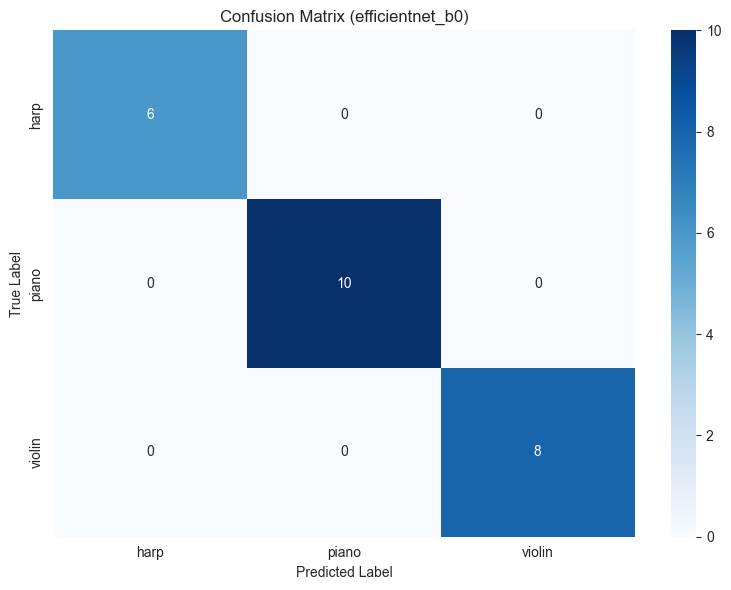

--- Результаты ResNet18 ---
Сохранено: C:\Users\krish\OneDrive\Desktop\ml1-music-finetuning\ml1-music-finetuning\experiments\reports\figures\training_curves_resnet18.png


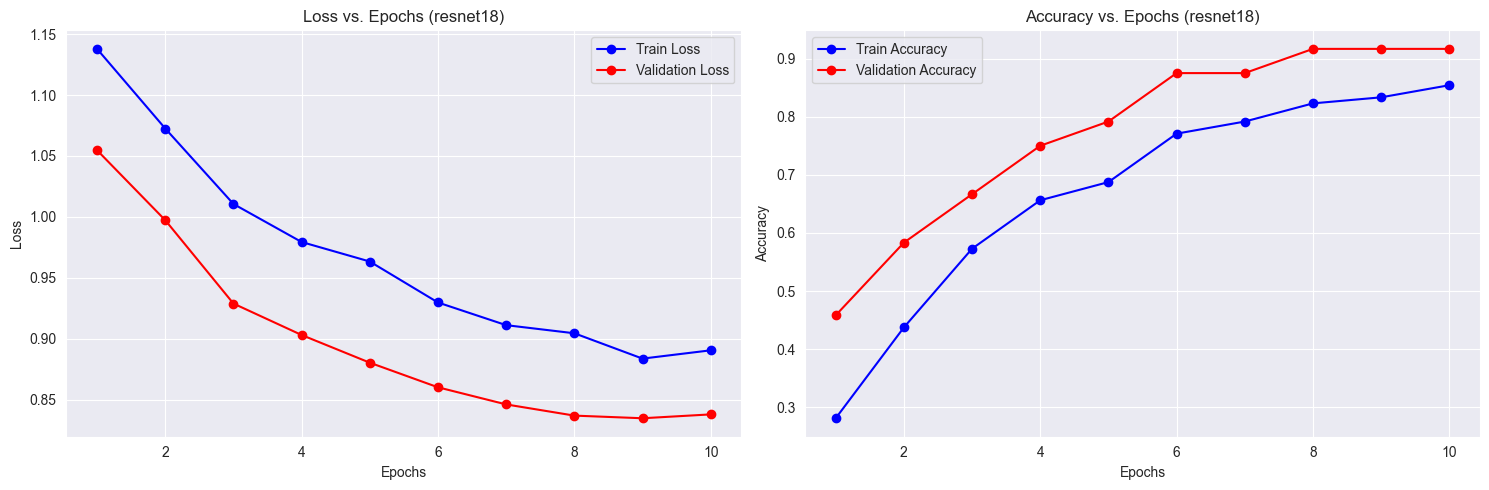

C:\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


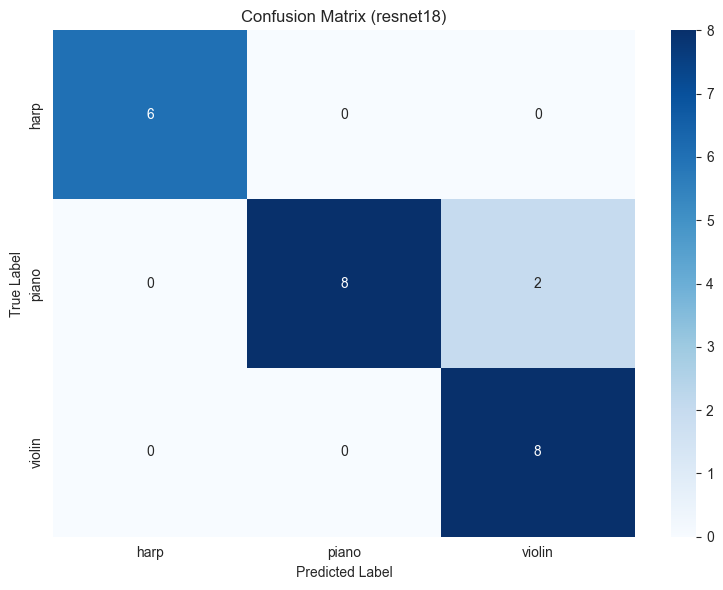

In [11]:
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Находим каталог experiments независимо от текущей рабочей директории
def find_experiments_dir():
    p = Path.cwd()
    while p != p.parent:
        candidate = p / "experiments"
        if (candidate / "config.py").exists():
            return candidate
        p = p.parent
    # если ноутбук запущен из experiments/*
    if (Path.cwd() / "config.py").exists():
        return Path.cwd()
    # простой fallback, если структура нетипична
    if (Path.cwd() / "experiments").exists():
        return Path.cwd() / "experiments"
    raise FileNotFoundError("Не найден каталог experiments с config.py")

# Базовые пути: модели и фигуры
EXP_DIR = find_experiments_dir()
MODELS_DIR = EXP_DIR / "models"
FIGURES_DIR = EXP_DIR / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

def plot_curves(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Потери
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title(f'Loss vs. Epochs ({model_name})')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    # Точность
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Train Accuracy')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title(f'Accuracy vs. Epochs ({model_name})')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    out_path = FIGURES_DIR / f'training_curves_{model_name}.png'
    plt.savefig(out_path)
    print(f'Сохранено: {out_path}')
    plt.show()

def plot_confusion_matrix(model, model_name, dataloader, device=None):
    # Загружаем лучшие веса
    ckpt_path = MODELS_DIR / f'best_{model_name}.pth'
    state_dict = torch.load(ckpt_path, map_location=(device if device else 'cpu'))
    model.load_state_dict(state_dict)

    if device is not None:
        model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            if device is not None:
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix ({model_name})')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    out_path = FIGURES_DIR / f'confusion_matrix_{model_name}.png'
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

print('--- Результаты EfficientNet-B0 ---')
plot_curves(effnet_history, 'efficientnet_b0')
plot_confusion_matrix(effnet_model, 'efficientnet_b0', val_loader, device=DEVICE)

print('--- Результаты ResNet18 ---')
plot_curves(resnet_history, 'resnet18')
plot_confusion_matrix(resnet_model, 'resnet18', val_loader, device=DEVICE)

## 5. Итоговые выводы и выбор модели

In [12]:
# Сводная таблица для сравнения
print('### Сводная таблица результатов ###')
print(f'| Метрика                  | EfficientNet-B0 | ResNet18 |')
print(f'|--------------------------|-----------------|----------|')
print(f'| **Лучшая точность (val)**  | {effnet_best_acc:.4f}           | {resnet_best_acc:.4f}    |')
print(f'| **Время обучения (сек)**   | {effnet_time:.2f}           | {resnet_time:.2f}    |')
print(f'| **Кол-во параметров**    | {effnet_params:,}     | {resnet_params:,} |')

### Сводная таблица результатов ###
| Метрика                  | EfficientNet-B0 | ResNet18 |
|--------------------------|-----------------|----------|
| **Лучшая точность (val)**  | 1.0000           | 0.9167    |
| **Время обучения (сек)**   | 268.89           | 262.37    |
| **Кол-во параметров**    | 4,011,391     | 11,178,051 |


**Вывод:** На основе полученных результатов, сравнительный анализ продемонстрировал, что архитектура EfficientNet-B0 обладает значительным превосходством над ResNet18 в контексте данной задачи классификации. При сопоставимых временных затратах на обучение, EfficientNet-B0 достигла максимальной точности на валидационном сете (100%), в то время как ResNet18 показала результат в 91.67%. Ключевым фактором, подчеркивающим архитектурную эффективность EfficientNet-B0, является достижение этого результата при существенно меньшем количестве параметров (~4.0 млн) по сравнению с ResNet18 (~11.2 млн). Данный факт указывает на более высокую репрезентативную мощность и лучшую параметрическую эффективность EfficientNet-B0. Следовательно, EfficientNet-B0 является объективно превосходящим выбором, обеспечивающим как более высокое качество классификации, так и меньшие вычислительные требования для инференса, что критически важно для развертывания в ресурсоограниченных средах, таких как CPU.
